# Homework 3 Part 2

## Course Name: Deep Learning
#### Lecturers: Dr. Beigy

---

#### Notebooks Supervised By: Zeinab Sadat Taghavi
#### Notebooks Prepared By: Zahra Khoramnejad, Mehran Sarmadi, Zahra Rahimi

**Contact**: Ask your questions in Quera

---

### Instructions:
- Complete all exercises presented in this notebook.
- Ensure you run each cell after you've entered your solution.
- After completing the exercises, save the notebook and <font color='red'>follow the submission guidelines provided in the PDF.</font>


---


# Text Generation

<p align='justify'>Text generation task involves generating new text based on a given input or a prompt. It is a natural language processing (NLP) task that aims to generate coherent and contextually relevant text.

In text generation, a model is trained on a large corpus of text data and learns the patterns and structures of the language. This model can then be used to generate new text by sampling from the learned distribution of words or characters.

Text generation has various applications, including chatbots, language translation, poetry generation, and content creation. It can be implemented using different techniques such as `recurrent neural networks (RNNs)`, `transformers`, and `Markov chains`.

The goal of text generation is to produce text that is fluent, coherent, and contextually relevant. It requires a deep understanding of the language and the ability to generate text that follows grammatical rules and maintains semantic coherence.</p>

## Charachter-level text generation

One stage of the task of text generation is mapping, which can be at the word or character level. At this stage, a number is assigned to each word or character.

In this exercise, we generate text at the character level. Because generating text at the word level, even though it leads to more meaningful outputs, requires a rich dataset with a high number of word repetitions.

We will implement models based on `recurrent networks` for text generation and compare the performance of different models. In the following, we will check the performance of the best models on different datasets and compare the results

The steps of this exercise are as follows:
1. Train RNN and LSTM
2. FineTuning
3. Experiment on different datasets

---
---

# 1. Train RNN and LSTM

## Imports

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import numpy as np
import pandas as pd
import random
import re
import string

import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

- We use the dataset of `Shakespeare's plays` as the main dataset for this exercise

In [14]:
# !wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt" -c -P {'data/'}

- Load data in amout of 30kb for training models

In [68]:
sh_data_file = "./data/input.txt"
sh_data = open(sh_data_file, 'r').read(30000)

## Charachter mapping

- For better performance of the model, we limit the set of allowed characters

In [69]:
chars = list(string.ascii_lowercase + '\n' + ' ' + ':' + '.')
vocab_size = len(chars)

In [70]:
# Mapping of char-index
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

## Preprocessing

In [71]:
def remove_extraneous_characters(data, valid_char_list):
    pattern = f"[^{re.escape(''.join(valid_char_list))}]"
    return re.sub(pattern, '', data)

In [72]:
sh_data = remove_extraneous_characters(sh_data.lower(), chars)
sh_data_size = len(sh_data)

# Extract indexes of data characters
sh_data = list(sh_data)
for i, ch in enumerate(sh_data):
    sh_data[i] = char_to_ix[ch]

sh_data = torch.tensor(sh_data).to(device)
sh_data = torch.unsqueeze(sh_data, dim=1)
sh_data.shape

torch.Size([29038, 1])

As we can see, in the sh_data we have 29038 charachters. And in this model we want to embed charachters not words, And e can't just give these charachters as indices to our model and expect an output index. so we need to embed them. We already know that there are only 30 charachters so we can use one-hot encoding without problem.

In [73]:
tmp = torch.zeros(sh_data.shape[0], 30)
for i in range(sh_data.shape[0]):
    tmp[i][sh_data[i][0]] = 1
sh_data = tmp
sh_data.shape

torch.Size([29038, 30])

## Modeling

- In this part define RNN and LSTM model, according to the mentioned characteristics and function inputs.


### RNN

In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=0.5 if self.dropout_enable else 0, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        self.hidden_state = torch.zeros(self.num_layers, self.hidden_size).to(device)
    
    def forward(self, input_seq):
        output, self.hidden_state = self.rnn(input_seq, self.hidden_state)
        output = self.decoder(output)
        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

### LSTM

In [75]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=512, num_layers=3, dropout_enable=False):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_enable = dropout_enable
        self.dropout = nn.Dropout(0.5)
        self.hidden_state = None
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        self.hidden_state = (torch.zeros(self.num_layers, self.hidden_size).to(device),
            torch.zeros(self.num_layers, self.hidden_size).to(device))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_state = self.lstm(input_seq, self.hidden_state)
        # print(lstm_out.shape)
        lstm_out = lstm_out[:,]
        output = self.decoder(lstm_out)
        return output

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))

## Training

In [76]:
def print_sample_output(model, data, data_size, test_output_len = 200):
    # Use this function to print sample that model generates from its current hidden state and random input character
    # test_output_len is total num of characters in output test sequence

    test_output = ""
    data_ptr = 0

    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]

        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr > test_output_len:
            break

    print("Train Sample +++++++++++++++++++++++++++++++++++++++++++++")
    print(test_output)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

- For construction of each sample in the dataset, the output sequence is
obtained from the shift of one character from the input sequence. For example, when sequence_length is 10 and our text is `Hello world`. The input sequence would be `Hello worl`, and the target sequence `ello world`.

In [77]:
def train_epoch(model, data, data_size, epoch, optimizer, seq_len=200):
    # seq_length is length of training data sequence
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    sample_number = 0
    # Define training process for one epoch of input model
    # At the end of every ten epochs, print current loss and a sample output of the model using print_sample_output function
    # Feed all data sample to model by iterating over input data
    for i in range(0, data_size - seq_len, seq_len):
        inputs = data[i:i+seq_len].to(device)
        targets = data[i+1:i+seq_len+1].to(device)
        model.init_hidden()
        outputs = model(inputs.float())
        # max_indices = torch.argmax(outputs, dim=1)
        # outputs = torch.unsqueeze(max_indices, dim=1)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        sample_number += 1

        if epoch % 10 == 0:
          print(f"Epoch {epoch+1}: Loss -> {total_loss / sample_number}")

    return total_loss / sample_number

In [85]:
def train_rnn(data, data_size, model_save_file):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.002
    epoch_num = 100
    losses = []
    # Define training process in the specified number of epochs for RNN model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage
    model = RNN(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    for epoch in range(epoch_num):
        print("Epoch:", epoch+1)
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), model_save_file)
    return losses

In [86]:
def train_lstm(data, data_size, model_save_file):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.002
    epoch_num = 100
    losses = []
    # Define training process in the specified number of epochs for LSTM model
    # Use train_epoch function for train the model for one epoch
    # Use Adam as optimizer
    # Save best model in model_save_file address for next usage
    model = LSTM(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers, dropout_enable=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    for epoch in range(epoch_num):
        print("Epoch:", epoch+1)
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), model_save_file)

    return losses

### RNN

In [87]:
rnn_sh_losses = train_rnn(sh_data, sh_data_size, './model_sh_rnn.pth')

Epoch: 1
Epoch 1: Loss -> 3.4029226303100586
Epoch 1: Loss -> 3.2802164554595947
Epoch 1: Loss -> 3.434178670247396
Epoch 1: Loss -> 3.4650675654411316
Epoch 1: Loss -> 3.7075666904449465
Epoch 1: Loss -> 3.72823965549469
Epoch 1: Loss -> 3.7351748262132918
Epoch 1: Loss -> 3.7273127734661102
Epoch 1: Loss -> 3.7039566040039062
Epoch 1: Loss -> 3.67820143699646
Epoch 1: Loss -> 3.6620479063554243
Epoch 1: Loss -> 3.647865911324819
Epoch 1: Loss -> 3.6296200935657206
Epoch 1: Loss -> 3.617848822048732
Epoch 1: Loss -> 3.602489709854126
Epoch 1: Loss -> 3.5809173434972763
Epoch 1: Loss -> 3.589390951044419
Epoch 1: Loss -> 3.6207413143581815
Epoch 1: Loss -> 3.6260796220679032
Epoch 1: Loss -> 3.6141524076461793
Epoch 1: Loss -> 3.5921790259225026
Epoch 1: Loss -> 3.571307821707292
Epoch 1: Loss -> 3.5538223308065664
Epoch 1: Loss -> 3.539523114760717
Epoch 1: Loss -> 3.5208138942718508
Epoch 1: Loss -> 3.5092822038210354
Epoch 1: Loss -> 3.4979191886054144
Epoch 1: Loss -> 3.48274710348

### LSTM

In [88]:
lstm_sh_losses = train_lstm(sh_data, sh_data_size, './model_sh_lstm.pth')

Epoch: 1
Epoch 1: Loss -> 3.3979601860046387
Epoch 1: Loss -> 3.3640434741973877
Epoch 1: Loss -> 3.3530704180399575
Epoch 1: Loss -> 3.324673652648926
Epoch 1: Loss -> 3.3098012924194338
Epoch 1: Loss -> 3.2943126360575357
Epoch 1: Loss -> 3.2732599122183665
Epoch 1: Loss -> 3.2420361936092377
Epoch 1: Loss -> 3.213029040230645
Epoch 1: Loss -> 3.1875482320785524
Epoch 1: Loss -> 3.1754210645502265
Epoch 1: Loss -> 3.15866090854009
Epoch 1: Loss -> 3.1513705987196703
Epoch 1: Loss -> 3.141840628215245
Epoch 1: Loss -> 3.130476951599121
Epoch 1: Loss -> 3.1185054183006287
Epoch 1: Loss -> 3.110057928982903
Epoch 1: Loss -> 3.10067715909746
Epoch 1: Loss -> 3.0948503770326314
Epoch 1: Loss -> 3.0891488432884215
Epoch 1: Loss -> 3.084976389294579
Epoch 1: Loss -> 3.0814219496466895
Epoch 1: Loss -> 3.0767381398574165
Epoch 1: Loss -> 3.0713449319203696
Epoch 1: Loss -> 3.0655304908752443
Epoch 1: Loss -> 3.063560623389024
Epoch 1: Loss -> 3.0613411090992115
Epoch 1: Loss -> 3.05820860181

## Generating texts

- A sample text to input the model

In [179]:
input_sample_text = 'First Citizen:\nYou are all resolved rather to die than to famish?\n'

def create_input_sample_dataset(input_sample_text):
    input_sample = remove_extraneous_characters(input_sample_text.lower(), chars)
    input_sample = list(input_sample)

    for i, ch in enumerate(input_sample):
        input_sample[i] = char_to_ix[ch]

    input_sample = torch.tensor(input_sample).to(device)
    input_sample = torch.unsqueeze(input_sample, dim=1)
    tmp = torch.zeros(input_sample.shape[0],30)
    for i in range(input_sample.shape[0]):
        tmp[i][input_sample[i][0]] = 1
    input_sample = tmp
    return input_sample

- This function generates the output generated by the model for the input sample, and if the input sample text is not given, it samples a sequence of original data and gives it to the model.

In [134]:
def generate_text(model, data, data_size, input_sample_test = None, output_len=1000):
    model.eval()
    data_ptr = 0
    test_output=""

    if input_sample_test is not None:
        index = 0
        seq_len = len(input_sample_test)
        input_seq = input_sample_test[index : index + seq_len-1]
    else:
        # If input sample not declared, select an initial string from the data of 10 characters randomly
        index = np.random.randint(data_size - 11)
        seq_len = 10
        input_seq = data[index : index + 9]

   # Set last hidden state of model by feeding input sequence to model
    input_seq = input_seq.to(device)

    # Last charachter feed to model
    if input_sample_test is not None:
        input_seq = input_sample_test[index + seq_len-1 : index + seq_len]
    else:
        input_seq = data[index + seq_len-1 : index + seq_len]

    while True:
        output = model(input_seq)

        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample().item()

        test_output += ix_to_char[index]
        input_seq[0][0] = index
        data_ptr += 1

        if data_ptr  > output_len:
            break

    print("Eaxmple of generated text --------------------------------------------------------------------------")
    print(test_output)
    print("----------------------------------------------------------------------------------------------------")

### RNN

In [135]:
best_model_rnn =  RNN(vocab_size, vocab_size, 512, 6).to(device)
best_model_rnn.load_model('./model_sh_rnn.pth')
print("best loss", min(rnn_sh_losses))
generate_text(best_model_rnn, sh_data.to(device), sh_data_size)

best loss 3.026148595481083
Eaxmple of generated text --------------------------------------------------------------------------
meuahasce:tse:
t:mleoeipet afn 
 tscoh g tmktyr:frgpoh ugonde nhatm f iywpruee d ig  
 u  oawmee:
 rse x
meneoaet
 gnroatgiiuc:ttis lhile h du
ftadtahdwatd eahk sr b
higphichkdougtdnae l  :ueed eridoagtrcetse tnwoh a lt
rhu  h  l::fatrtiburca t ihr cfe apte hmtno.d l  ca tythcisr haaiddar:mdr medpaaogthie rit
tttwtbi booe nrar a  e


efori
  :vu hahiwhlo:rratr rktdkemaa
 wbn
rpditl hrhaht:ealnotietsdm  rw:e
atstue oewhwateonin kmyaehhsa
h dhth.htiitlrhiri ahugatrh
s fwumba dghe w:rh rortrrrtm aohhrstrtshit:mh tkrllal: rmheer ohyheasislh  tkt
siclkeumaa ieeldrtntod.het
htetoataapfhctrfrtmia re ptttuapfoite
fhnetumoerlta uhmeoi mrytmduhuebrt udhed sd hutc b
e vrd eh mksdee aliht tmh:dle miwme
dai htthuroa.i
haphstm uud phswsr edgoh hteeqtoo ai etxa hadhe  pe 

hmfhtea iwlo itrm htumu ruegumtnhhutrhurehaad dgtadetdlheot l
  o  he mf f tshada ht  unuhm
d 
 ay  ts

### LSTM

In [136]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_lstm.pth')
print("best loss", min(lstm_sh_losses))
generate_text(best_model_lstm, sh_data.to(device), sh_data_size)

best loss 0.015320067998555746
Eaxmple of generated text --------------------------------------------------------------------------
i nnnn  cn: nnnn   nnnn dtn   m n bnntn       l ntdnct         n   nnnntn:   t t      dnncwbtncpb
ncpbtnt: :dn ttn t  t tdv  lw dwct pt  tpdt ln    ltn   :  p lnn       t    t     tt ct tt  mctlt.    pt: t ltlkt tt      lt  tt  l gt:tw     gw tlnttww ltw tt  t   wwptlt  t:tlt ttt t    ttttt: ttltt tctw tt tttpt  t  tttttttw tttt:t  ttwtlt tttcww:tt tttttttttttwtdtwttt tt:tttttt  t ttttt tp:tt t:t ttltw t  ltt tt: ttpcwl   tht  twctbtttpwct  tttkt   ttt   tt tt cw  t   w st dt  t:wtt:tctu ht  tt      ttttttct  ttdt  w ttt :tttdt  tt t: tmtt tt:t dtlt tw tttw t ttttt t   tt dt ttntt l:  tt ttt ttttpt  tt: tttttttt   tt t   t tww tl :dttcwctt t tt:ttttct :t  tt twt   :tt  tttttttttts:tttttttdttttttptttht tttt   ttptmttttt t ttt tt ttt ttttt::ttt ttttmtttttt:ttdt: ttttt ttt ttttt tttttt ttt:tttthtt tttctwt:t t:ttttt htdwcpctttl ttttttttttttt t tttttttttttt: tt

## Plotting the losses

In [97]:
def plot_losses(losses):
    xpoints = np.array(range(len(losses)))
    ypoints = np.array(losses)

    plt.plot(xpoints, ypoints, color='blue',label='losses')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

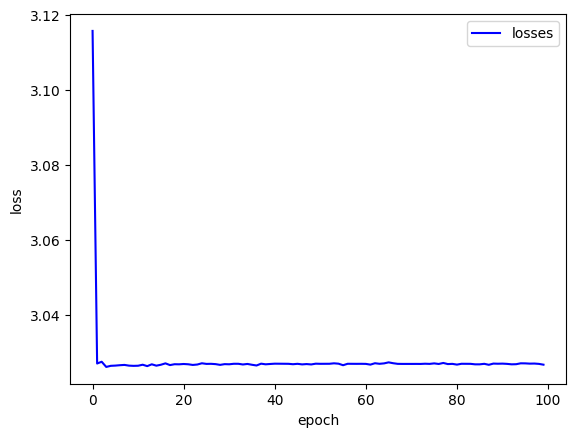

In [98]:
plot_losses(rnn_sh_losses)

### LSTM

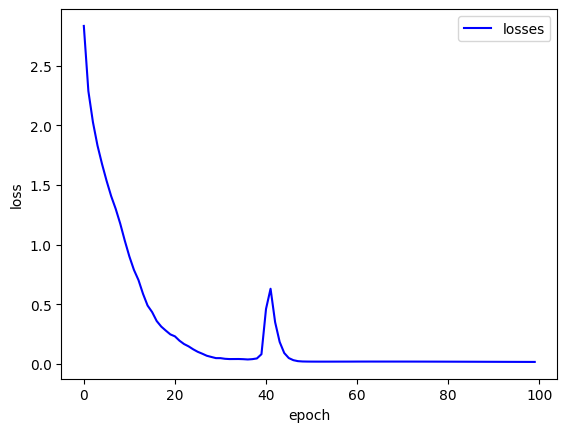

In [99]:
plot_losses(lstm_sh_losses)

## Report

According to the texts generated from different models and the losses during the training process of the models, analyze what is the reason for the difference in the result of models.

Which model works better and what do you think are the reasons?

<font color='#73FF73'><b>Your answer : </b></font></br>
As we can see, LSTM has performed better than RNN which was expectable. the reason for that is that RNN's have a pretty simple structure and suffer from vanishing gradient problem. That's why our RNN model has almost learned nothing! This model also suffers from exploding gradient problem. However the LSTM structure have solved these problem by using different gates. So the LSTM performs better than RNN. However, we can see a spike in the LSTM plot, but it was completely fine because the model has revived from that. Generally the spikes in the RNN are much more than in LSTM.

---
---

# 2. FineTuning

FineTuning is a technique used in neural network training where a pre-trained model is further trained on a new task or dataset. It allows us to leverage the knowledge and representations learned by a pre-trained model and adapt it to a specific task or domain.

In this exercise, we first train the models with a `wikipedia` dataset that contains english texts, then we fine-tune this pre-trained model again with the Shakespeare play dataset to check the effect of this method on different models.

## Load Wikipedia dataset

In [100]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz

In [101]:
# !tar -xvzf '/content/wikitext-2.tgz' -C '/content/data'

In [102]:
# !cat './data/wikitext-2/train.csv' | tr -d '\n' > ./data/wikitext.txt

## Preprocessing

In [107]:
def clean_wiki_data(data):
    repl=''
    data=re.sub('\(', repl, data)
    data=re.sub('\)', repl, data)
    for pattern in set(re.findall("=.*=",data)):
        data=re.sub(pattern, repl, data)
    for pattern in set(re.findall("<unk>",data)):
        data=re.sub(pattern,repl,data)
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl=''
        if pattern=='-':
            repl=' '
        if pattern!='.' and pattern!="\'":
            data=re.sub("\\"+pattern, repl, data)

    return data

def load_data(filepath):
    f=open(filepath, encoding="utf-8")
    return f.read()

In [109]:
wikidata=load_data("./data/wikitext.txt")
data=wikidata[:]
data=clean_wiki_data(data)
wikiPreprocessed_file = open("./data/wiki_preprocesed.txt", "w", encoding="utf-8")
f = wikiPreprocessed_file.write(data)
wikiPreprocessed_file.close()

- Load data in amount of 50kb for finetuning

In [110]:
wi_data_file = "./data/wiki_preprocesed.txt"
wi_data = open(wi_data_file, 'r', encoding="utf-8").read(50000)

In [111]:
wi_data = remove_extraneous_characters(wi_data.lower(), chars)
wi_data_size = len(wi_data)

wi_data = list(wi_data)
for i, ch in enumerate(wi_data):
    wi_data[i] = char_to_ix[ch]

wi_data = torch.tensor(wi_data).to(device)
wi_data = torch.unsqueeze(wi_data, dim=1)

In [112]:
tmp = torch.zeros(wi_data.shape[0],30)
for i in range(wi_data.shape[0]):
    tmp[i][wi_data[i][0]] = 1
wi_data = tmp
wi_data.shape

torch.Size([48980, 30])

## Pre-training by wikipedia dataset

### RNN

In [113]:
rnn_wi_losses = train_rnn(wi_data, wi_data_size, './model_wi_rnn.pth')

Epoch: 1
Epoch 1: Loss -> 3.4099388122558594
Epoch 1: Loss -> 3.2409406900405884
Epoch 1: Loss -> 3.4967194398244223
Epoch 1: Loss -> 3.449113965034485
Epoch 1: Loss -> 3.8370487213134767
Epoch 1: Loss -> 3.753140608469645
Epoch 1: Loss -> 4.0013435908726285
Epoch 1: Loss -> 3.971522241830826
Epoch 1: Loss -> 3.9046865039401584
Epoch 1: Loss -> 3.8313018321990966
Epoch 1: Loss -> 3.762943289496682
Epoch 1: Loss -> 3.698377847671509
Epoch 1: Loss -> 3.6472197495974026
Epoch 1: Loss -> 3.6070864711488997
Epoch 1: Loss -> 3.5695178667704264
Epoch 1: Loss -> 3.5251612067222595
Epoch 1: Loss -> 3.491250893648933
Epoch 1: Loss -> 3.459774480925666
Epoch 1: Loss -> 3.431560240293804
Epoch 1: Loss -> 3.400501751899719
Epoch 1: Loss -> 3.3798016707102456
Epoch 1: Loss -> 3.3523286147551103
Epoch 1: Loss -> 3.3383308597232983
Epoch 1: Loss -> 3.3184953133265176
Epoch 1: Loss -> 3.300436677932739
Epoch 1: Loss -> 3.2858024743887095
Epoch 1: Loss -> 3.2685006194644504
Epoch 1: Loss -> 3.2542269911

### LSTM

In [114]:
lstm_wi_losses = train_lstm(wi_data, wi_data_size, './model_wi_lstm.pth')

Epoch: 1
Epoch 1: Loss -> 3.4017765522003174
Epoch 1: Loss -> 3.3621556758880615
Epoch 1: Loss -> 3.2643251419067383
Epoch 1: Loss -> 3.23603892326355
Epoch 1: Loss -> 3.2056350708007812
Epoch 1: Loss -> 3.182211716969808
Epoch 1: Loss -> 3.1551805564335416
Epoch 1: Loss -> 3.1244528591632843
Epoch 1: Loss -> 3.0957329273223877
Epoch 1: Loss -> 3.0664330244064333
Epoch 1: Loss -> 3.0530359094793145
Epoch 1: Loss -> 3.037803669770559
Epoch 1: Loss -> 3.0267197902386007
Epoch 1: Loss -> 3.023831077984401
Epoch 1: Loss -> 3.017516771952311
Epoch 1: Loss -> 3.005606010556221
Epoch 1: Loss -> 2.997122988981359
Epoch 1: Loss -> 2.98895529905955
Epoch 1: Loss -> 2.982387291757684
Epoch 1: Loss -> 2.9717020988464355
Epoch 1: Loss -> 2.970779839016142
Epoch 1: Loss -> 2.9597483656623145
Epoch 1: Loss -> 2.9562740533248237
Epoch 1: Loss -> 2.949054330587387
Epoch 1: Loss -> 2.9458001136779783
Epoch 1: Loss -> 2.9427721867194543
Epoch 1: Loss -> 2.9371755123138428
Epoch 1: Loss -> 2.9329031280108

## Finetuning by Shakespeare

- Define the following functions to use the previous model as a pre-trained model and fine-tunes it using Shakespeare's plays dataset with lower learning rate.

In [115]:
def finetune_rnn(data, data_size, model_save_file, model_pretrained_path):
    # RNN parameters
    hidden_size = 512
    num_layers = 6
    lr = 0.001
    epoch_num = 100
    losses = []
    model = RNN(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers)
    model.to(device)
    model.load_state_dict(torch.load(model_pretrained_path))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch_num):
        print("Epoch:", epoch+1)
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)
        torch.save(model.state_dict(), model_save_file)
    return losses

In [116]:
def finetune_lstm(data, data_size, model_save_file, model_pretrained_path):
    # LSTM parameters
    hidden_size = 512
    num_layers = 3
    lr = 0.001
    epoch_num = 100
    losses = []
    model = LSTM(input_size=vocab_size, output_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers)
    model.to(device)
    model.load_state_dict(torch.load(model_pretrained_path))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch_num):
        loss = train_epoch(model, data, data_size, epoch, optimizer)
        losses.append(loss)
        torch.save(model.state_dict(), model_save_file)
    return losses

### RNN

In [117]:
rnn_sh_finetune_losses = finetune_rnn(sh_data, sh_data_size, './model_sh_finetune_rnn.pth', './model_wi_rnn.pth')

Epoch: 1
Epoch 1: Loss -> 4.095983505249023
Epoch 1: Loss -> 3.9056105613708496
Epoch 1: Loss -> 3.802647590637207
Epoch 1: Loss -> 3.6455183625221252
Epoch 1: Loss -> 3.577997922897339
Epoch 1: Loss -> 3.5627158085505166
Epoch 1: Loss -> 3.524803331920079
Epoch 1: Loss -> 3.465148836374283
Epoch 1: Loss -> 3.4161928759680853
Epoch 1: Loss -> 3.3895944356918335
Epoch 1: Loss -> 3.3633935668251733
Epoch 1: Loss -> 3.3311475118001304
Epoch 1: Loss -> 3.31106292284452
Epoch 1: Loss -> 3.2917280197143555
Epoch 1: Loss -> 3.2705731868743895
Epoch 1: Loss -> 3.252301663160324
Epoch 1: Loss -> 3.235229155596565
Epoch 1: Loss -> 3.221486290295919
Epoch 1: Loss -> 3.2129070633336116
Epoch 1: Loss -> 3.203481435775757
Epoch 1: Loss -> 3.197564136414301
Epoch 1: Loss -> 3.1896517276763916
Epoch 1: Loss -> 3.181315743404886
Epoch 1: Loss -> 3.171656926472982
Epoch 1: Loss -> 3.1626978015899656
Epoch 1: Loss -> 3.1578397934253397
Epoch 1: Loss -> 3.1517438093821206
Epoch 1: Loss -> 3.14860962118421

### LSTM

In [118]:
lstm_sh_finetune_losses = finetune_lstm(sh_data, sh_data_size, './model_sh_finetune_lstm.pth', './model_wi_lstm.pth')

Epoch 1: Loss -> 9.747041702270508
Epoch 1: Loss -> 9.027204036712646
Epoch 1: Loss -> 8.536153316497803
Epoch 1: Loss -> 8.03773844242096
Epoch 1: Loss -> 7.68295316696167
Epoch 1: Loss -> 7.554662863413493
Epoch 1: Loss -> 7.489643846239362
Epoch 1: Loss -> 7.316824376583099
Epoch 1: Loss -> 7.236314349704319
Epoch 1: Loss -> 7.188634824752808
Epoch 1: Loss -> 7.135574167424982
Epoch 1: Loss -> 7.102396408716838
Epoch 1: Loss -> 7.129679753230168
Epoch 1: Loss -> 7.0697133881705145
Epoch 1: Loss -> 6.9819149335225426
Epoch 1: Loss -> 6.910319566726685
Epoch 1: Loss -> 6.849277945125804
Epoch 1: Loss -> 6.794619984096951
Epoch 1: Loss -> 6.803239245163767
Epoch 1: Loss -> 6.81604311466217
Epoch 1: Loss -> 6.7643099058242075
Epoch 1: Loss -> 6.7022177522832695
Epoch 1: Loss -> 6.67378046201623
Epoch 1: Loss -> 6.6723370750745135
Epoch 1: Loss -> 6.6354958152771
Epoch 1: Loss -> 6.586817337916448
Epoch 1: Loss -> 6.574929413972078
Epoch 1: Loss -> 6.572093452726092
Epoch 1: Loss -> 6.53

## Plotting Losses

In [119]:
def plot_losses_together(losses1, losses2):
    xpoints = np.array(range(len(losses1)))
    ypoints1 = np.array(losses1)
    ypoints2 = np.array(losses2)

    plt.plot(xpoints, ypoints1, color='blue',label='base_losses' )
    plt.plot(xpoints, ypoints2, color='red',label='finetune_losses' )
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

### RNN

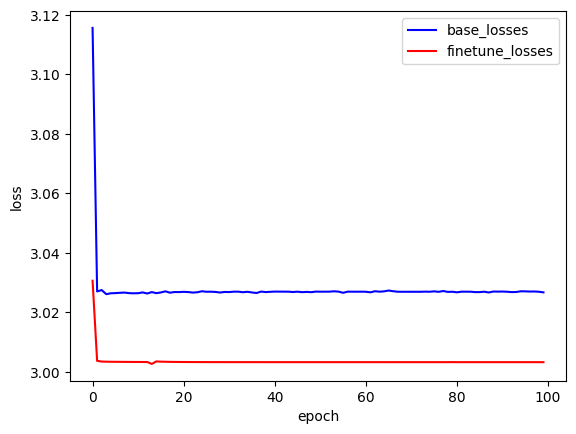

In [120]:
plot_losses_together(rnn_sh_losses, rnn_sh_finetune_losses)

### LSTM

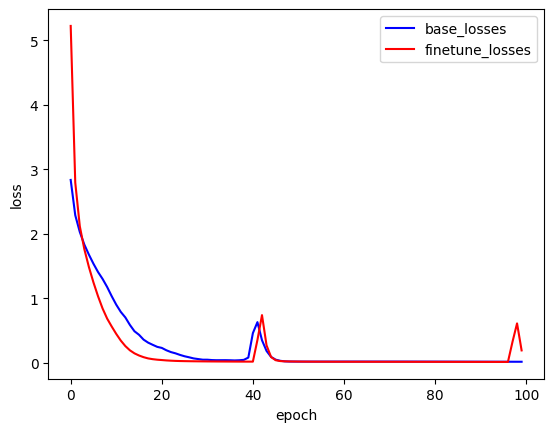

In [121]:
plot_losses_together(lstm_sh_losses, lstm_sh_finetune_losses)

## Report

As you can see, fine-tuning has an effect in improving the training of the main model.

By analyzing the obtained results, state the advantage of finetuning after pre-training the model by public dataset, and compare its performance in different models

<font color='#73FF73'><b>Your answer : </b></font></br>
As we can see in the losses, fine tuning has improved both models perfomance. However we can see more improvement in the RNN model compared to LSTM model and it is because LSTM is a better model for time series data and it can fit the data well. So if we use pretraining the only difference that we can see is faster convergence. But for RNN it has resulted in faster convergence and better results too. this can be because of using different datasets. In general fine tuning can improve model performance dramatically.

----
----

# 3. Experiment on different datasets

In the previous section, you saw the performance results of the text generation model using the Shakespeare plays dataset. In the following, you will check the results of the LSTM model on the dialogues of the `Friends series`

## Load dataset

In [122]:
# !wget https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-08/friends.csv -O ./data/Friends.csv

## preprocessing

In [123]:
friends = pd.read_csv('./data/Friends.csv')
friends = friends.dropna()
friends = friends[friends['speaker'].str.contains('SCENE')==False]
friends['speaker'] = friends['speaker'].apply(lambda sp: sp.lower().capitalize().split(' ')[0])
friends_texts = friends.drop(['episode','season','scene','utterance'], axis='columns')
friends_texts.head()

,text,speaker
0,There's nothing to tell! He's just some guy I ...,Monica
1,"C'mon, you're going out with the guy! There's ...",Joey
2,"All right Joey, be nice. So does he have a hum...",Chandler
3,"Wait, does he eat chalk?",Phoebe
4,"(They all stare, bemused.)",Scene


In [124]:
f = open("./data/fiends.txt", "w")
for i,row in friends_texts.iterrows():
    f.write(row['speaker'] + ':\n' + row['text'] + '\n\n')

f.close()

In [125]:
fr_data_file = "./data/fiends.txt"
fr_data = open(fr_data_file, 'r', encoding='utf-8').read(30000)
fr_data = remove_extraneous_characters(fr_data.lower(), chars)
fr_data_size = len(fr_data)

fr_data = list(fr_data)
for i, ch in enumerate(fr_data):
    fr_data[i] = char_to_ix[ch]

fr_data = torch.tensor(fr_data).to(device)
fr_data = torch.unsqueeze(fr_data, dim=1)

In [127]:
tmp = torch.zeros(fr_data.shape[0],30)
for i in range(fr_data.shape[0]):
    tmp[i][fr_data[i][0]] = 1
fr_data = tmp
fr_data.shape

torch.Size([28651, 30])

## Train finetuned LSTM by friends dataset

In [128]:
lstm_fr_finetune_losses = finetune_lstm(fr_data, fr_data_size, './model_fr_lstm.pth', './model_wi_lstm.pth')

Epoch 1: Loss -> 7.1761980056762695
Epoch 1: Loss -> 7.999434471130371
Epoch 1: Loss -> 7.717687765757243
Epoch 1: Loss -> 8.062104105949402
Epoch 1: Loss -> 7.931585216522217
Epoch 1: Loss -> 7.961449384689331
Epoch 1: Loss -> 7.8919084412711005
Epoch 1: Loss -> 8.225859105587006
Epoch 1: Loss -> 8.343492984771729
Epoch 1: Loss -> 8.312360620498657
Epoch 1: Loss -> 8.144988363439387
Epoch 1: Loss -> 8.082529703776041
Epoch 1: Loss -> 8.015045606173002
Epoch 1: Loss -> 7.940205267497471
Epoch 1: Loss -> 7.852701505025228
Epoch 1: Loss -> 7.806293725967407
Epoch 1: Loss -> 7.720376940334544
Epoch 1: Loss -> 7.557850705252753
Epoch 1: Loss -> 7.480721448597155
Epoch 1: Loss -> 7.332038736343383
Epoch 1: Loss -> 7.290704227629162
Epoch 1: Loss -> 7.270437500693581
Epoch 1: Loss -> 7.254230250482974
Epoch 1: Loss -> 7.23619016011556
Epoch 1: Loss -> 7.1719200134277346
Epoch 1: Loss -> 7.168609142303467
Epoch 1: Loss -> 7.134340763092041
Epoch 1: Loss -> 7.097731811659677
Epoch 1: Loss -> 7

## Generating texts

In [130]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
print("best loss", min(lstm_fr_finetune_losses))
generate_text(best_model_lstm, fr_data.to(device), fr_data_size)

best loss 0.013927585984681166
Eaxmple of generated text --------------------------------------------------------------------------
bbtn glt glrtggtclyttglg t t  tt y tt  yytyy   y gny t y y    y ytt y y t ytt  tt  y yyy y   tyyutyytyyyy tyy t y t yy yy ytyyy yt y tc y   y   t y    gny t   y   y  yy t  tt   y    yyty y  yyy      y  lt t y y t y t n t r r n gng g
gr gng glglglyr gng grtglg cptlt  gn  c l t r n t r r lngn  c l tntd y l t lrt gry d.y nrldnndn r c l
l t l t l t l t ld glyr d:l
ldlnd tld yd trldlnd yd luyd yrtlnn ldndlyylryldl t dabh  y c y tlldln r t r g t clnrdll trcll r t rcl   r   glggg t r  r yg ggn  yy  y yyg gltrlr ryy g glgllr d y lrt lrtyg gllrl t rrnyglt lrt r
ryryryrygltr y dlyd ydnyrlnyd
y ndlyllt d ldl d yyd
l tlydiy  yy d ylnyllryd ldrlin dlyl tllydyyll l
ylyylyylyydlyr  lygl d yd s d
ldl d lyduyldlyrdldldlyu d c
yyd.yrdlyd y ddlr yd
y d.l ryd
y d
y d
gdl  rd:yrdjydlbly    ddjrrdsd:yl yydjyj yd y.d
y d
y d
y d
y d
y d
y d
y dyyldjy ddjrd
yr d c yydly d ydlyr g

- As you can see, the LSTM network has been able to learn the features of different datasets in terms of sentence length and writing style and use it in text generation.

## The output of finetuned models on different datasets on the input sample

- In this section, you can see the result of the text generated by models with a sample input text.

In [175]:
input_sample_text = "Hello, have a nice day.\n"

In [181]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_fr_lstm.pth')
generate_text(best_model_lstm, fr_data.to(device), fr_data_size, create_input_sample_dataset(input_sample_text).to(device),100)

Eaxmple of generated text --------------------------------------------------------------------------

ltltlllhhhljl ln thll hlll hh hhll  h  nl tnh nlhnhnhlhlhlll  hlhl  lly:hytn nn nn hhhlnhhhlhhhlhlll
----------------------------------------------------------------------------------------------------


In [182]:
best_model_lstm =  LSTM(vocab_size, vocab_size, 512, 3).to(device)
best_model_lstm.load_model('./model_sh_finetune_lstm.pth')
generate_text(best_model_lstm, sh_data, sh_data_size, create_input_sample_dataset(input_sample_text).to(device),100)

Eaxmple of generated text --------------------------------------------------------------------------
vgclrrrrrrrrrrrrrrrrrrrrrrrrrrrrgrgrgrgr:yrrrrrrc cscrgrctcrcrgrgrgrdrdrcrcrptgr r        g frgi     
----------------------------------------------------------------------------------------------------


## Report

According to the sample input and output produced by the fine-tuned model with the Shakespeare dataset and the Friends dataset, which output is more meaningful and what is the reason for this difference?

<font color='#73FF73'><b>Your answer : </b></font></br>
As we can see in the output, the output of the model tuned with shakespere dataset is not that meaningfull and only has some structure. However the output of the model tuned with friends has produced more meaningfull sentences. Although both of them struggle to make correct sentences with correct words we can see that the friends model has done a better job. However this comparison is so invalid because we need to define metrics in order to assess each models performance not by just using quality words.

----
----